# Import Necessary Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white #Homoscedasticity
from statsmodels.stats.outliers_influence import variance_inflation_factor #Multicollinearity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Import the Data

In [2]:
advertising = pd.read_csv("advertising.csv")
advertising

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


# Exploratory Data Analysis

## Statistical Description

In [3]:
advertising.describe(include='all')

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


### Check for Null Data

In [4]:
advertising.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

### Check for Duplicate Data

In [5]:
advertising.duplicated().sum()

0

## Distribution Plot

[]

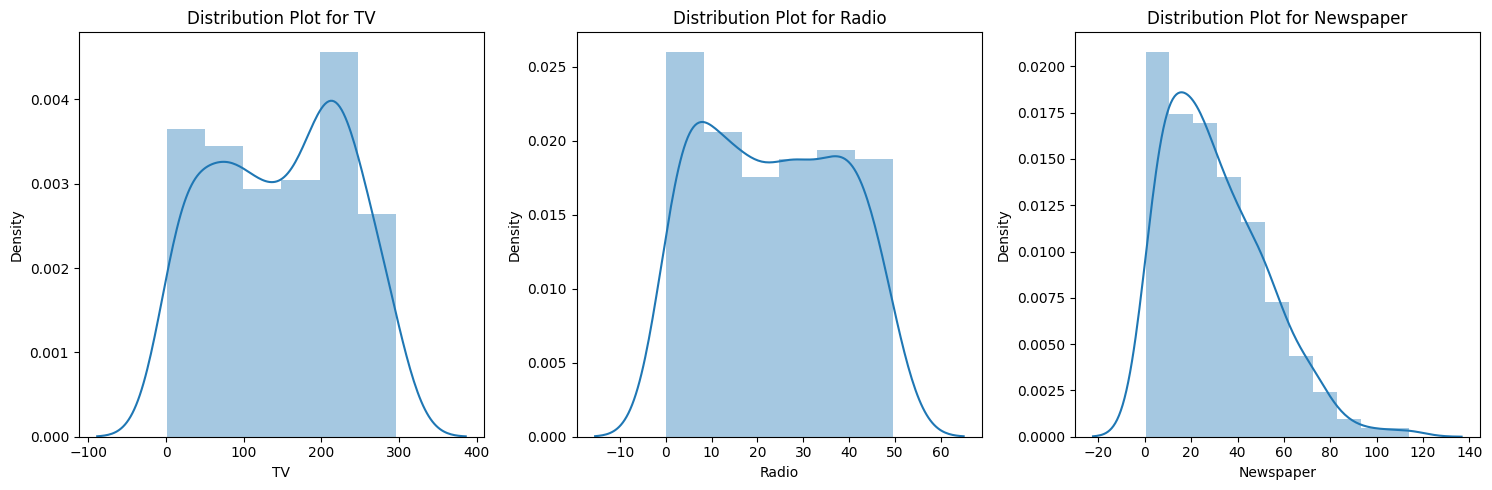

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(advertising.shape[1]-1):
    sns.distplot(advertising.iloc[:,i], ax = axes[i])
    axes[i].set_title(f'Distribution Plot for {advertising.columns[i]}')
plt.tight_layout()
plt.plot()

## Heatmap Correlation Plot

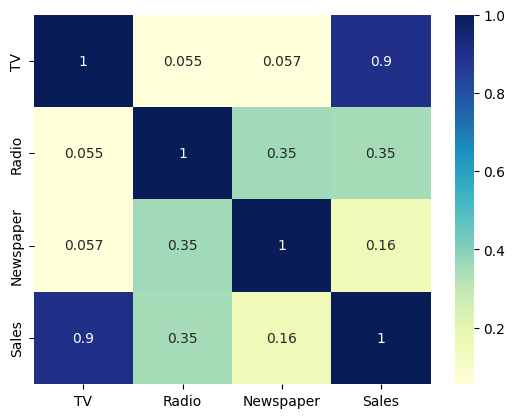

In [7]:
sns.heatmap(advertising.corr(), cmap="YlGnBu", annot = True)
plt.show()

## Box Plot

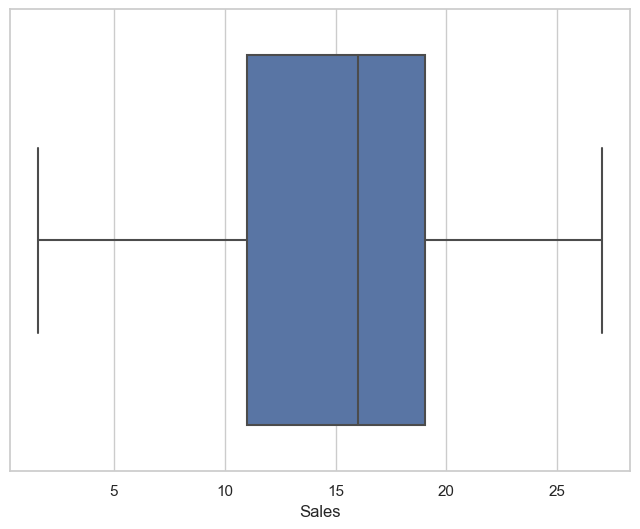

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.boxplot(x=advertising['Sales'])
plt.show()

## Linear Relationship

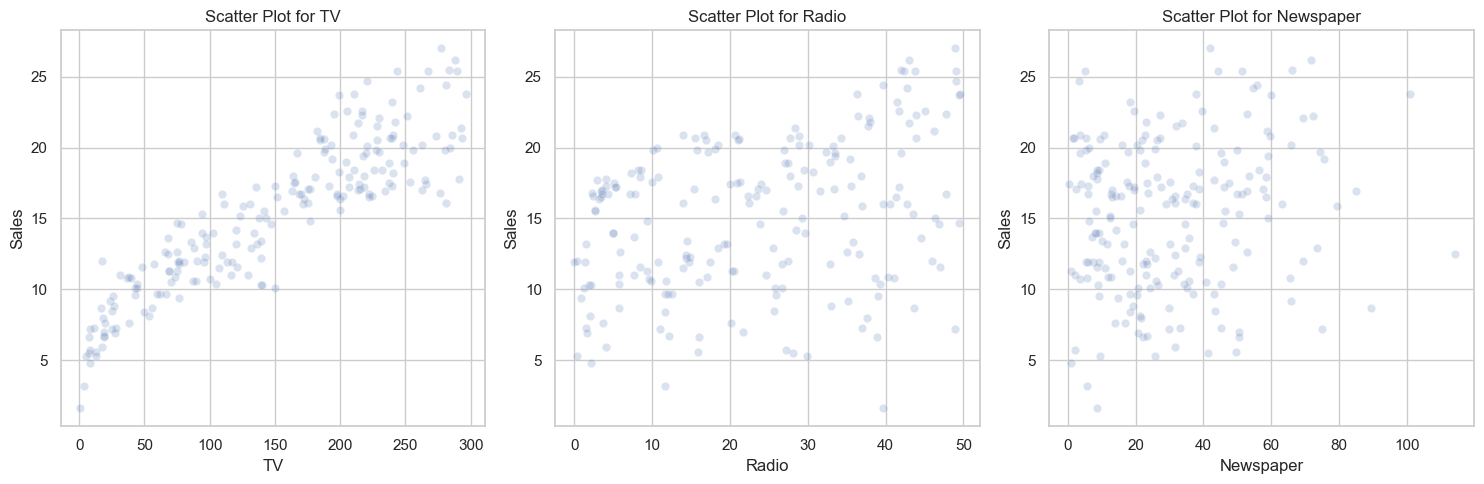

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(advertising.shape[1]-1):
    sns.scatterplot(x=advertising.iloc[:,i],y=advertising.iloc[:,3],ax=axes[i],alpha=0.2)
    axes[i].set_title(f'Scatter Plot for {advertising.columns[i]}')

plt.tight_layout()
plt.show()

The scatter plot for TV shows a clear linear relationship while the relationships of the other two are unclear.

# Data Preprocessing 

### Define independent and dependent variables

In [10]:
X = advertising.iloc[:, 0:3] 
y = advertising.iloc[:,-1]

### Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 556)

### Check for OLS Assumption

#### Check for Multicolinearity

In [12]:
variables = advertising.iloc[:,0:3]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,2.486772,TV
1,3.285462,Radio
2,3.055245,Newspaper


Notice that the VIFs for three of them are below 10, that means all the variables have no multicollinearity for each other.

#### Feature Importance for Linear Regression

In [13]:
pre_model = LinearRegression()
pre_model.fit(X_train, y_train)
y_pred = pre_model.predict(X_test)
summary = {
    "Column": ["Intercept"] + X.columns.tolist(), 
    "Coefficient": [pre_model.intercept_] + pre_model.coef_.tolist() 
}
summary_table = pd.DataFrame(summary)
print(summary_table)

      Column  Coefficient
0  Intercept     4.253445
1         TV     0.055611
2      Radio     0.110564
3  Newspaper     0.003953


     Feature  Importance
1      Radio    0.110564
0         TV    0.055611
2  Newspaper    0.003953


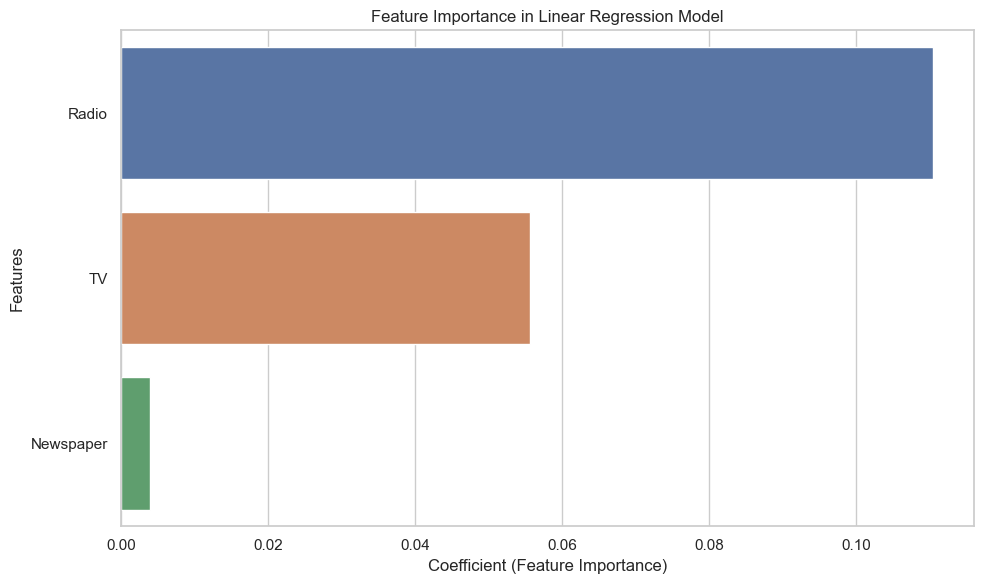

In [14]:
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": pre_model.coef_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.xlabel("Coefficient (Feature Importance)")
plt.ylabel("Features")
plt.title("Feature Importance in Linear Regression Model")
plt.tight_layout()
plt.show()

#### Check for Autocorrelation

In [15]:
x_train = sm.add_constant(X_train)
model_sm = sm.OLS(y_train,x_train).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     415.8
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           2.80e-68
Time:                        15:51:53   Log-Likelihood:                -271.15
No. Observations:                 140   AIC:                             550.3
Df Residuals:                     136   BIC:                             562.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2534      0.384     11.081      0.0

It's worth noting that while the Durbin Watson test doesn't indicate a significant difference from 2 (suggesting no autocorrelation among variables), the p-value of the Newspaper variable is notably higher than the set alpha value. This observation aligns with the weak correlation previously seen in the heatmap between Newspaper and Sales variables. Additionally, the Feature Importance plot underscores the insignificance of the Newspaper variable. Consequently, we can confidently conclude that the Newspaper variable lacks importance and can be safely omitted.

In [16]:
new_X = X.drop(columns="Newspaper")
new_X_train = X_train.drop(columns="Newspaper")
new_X_test = X_test.drop(columns="Newspaper")

# Modeling

## Linear Regression

#### Sklearn Model

In [17]:
new_model = LinearRegression()
new_model.fit(new_X_train, y_train)
new_summary = {
    "Column": ["Intercept"] + new_X.columns.tolist(), 
    "Coefficient": [new_model.intercept_] + new_model.coef_.tolist() 
}
new_summary_table = pd.DataFrame(new_summary)
print(new_summary_table)

      Column  Coefficient
0  Intercept     4.329853
1         TV     0.055656
2      Radio     0.112323


#### Statsmodel Model

In [18]:
new_x_train = sm.add_constant(new_X_train)
new_model_sm = sm.OLS(y_train,new_x_train).fit()
print(new_model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     626.6
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.16e-69
Time:                        15:51:53   Log-Likelihood:                -271.31
No. Observations:                 140   AIC:                             548.6
Df Residuals:                     137   BIC:                             557.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3299      0.359     12.063      0.0

In [19]:
y_train_pred = new_model.predict(new_X_train)

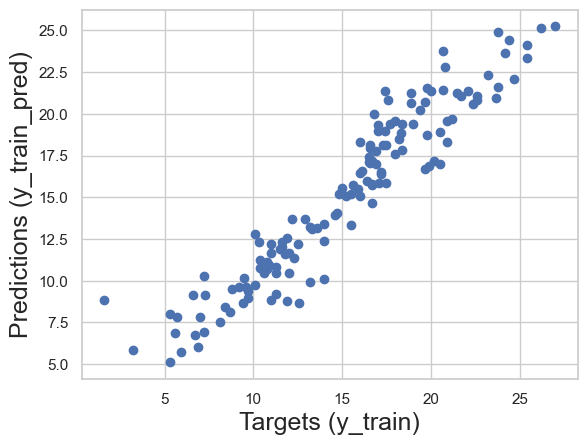

In [20]:
plt.scatter(y_train, y_train_pred)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_train_pred)',size=18)
plt.show()

This indicates that the predicted values (y_train_pred) closely align with the actual data (y_train).

### Linear Regression Assumption

#### Recheck for Normality

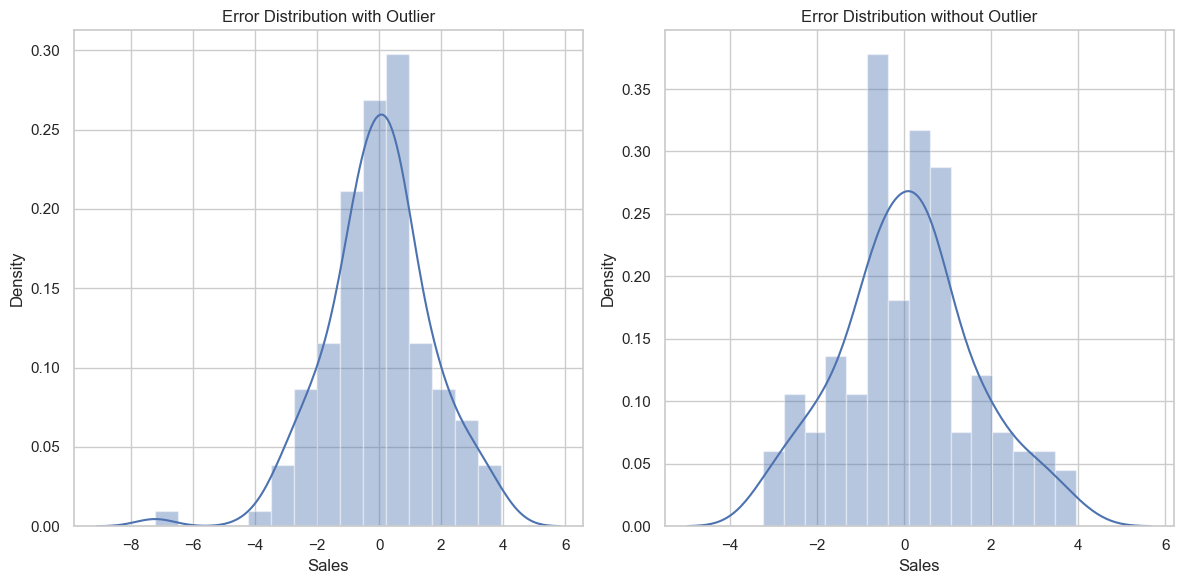

In [21]:
res = (y_train - y_train_pred)
fig_error, axes_error = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(res, bins=15, ax=axes_error[0])
axes_error[0].set_title('Error Distribution with Outlier')
sns.distplot(res[res > res.quantile(0.01)], bins=15, ax=axes_error[1])
axes_error[1].set_title('Error Distribution without Outlier')
plt.tight_layout()
plt.show()

In [22]:
residuals = new_model_sm.resid
jb_test_statistic, jb_p_value = stats.jarque_bera(residuals)
jb_test_statistic_without_outlier, jb_p_value_without_outlier = stats.jarque_bera(residuals[residuals>residuals.quantile(0.01)])
alpha = 0.05
print(f"p-value with outlier = {jb_p_value:.3f} \np-value without outlier = {jb_p_value_without_outlier:.3f}")
if jb_p_value > alpha:
    print("Residuals with outliers are normally distributed.")
else:
    print("Residuals with outliers are not normally distributed.")
if jb_p_value_without_outlier > alpha:
    print("Residuals without outliers are normally distributed.")
else:
    print("Residuals without outliers are not normally distributed.")


p-value with outlier = 0.000 
p-value without outlier = 0.745
Residuals with outliers are not normally distributed.
Residuals without outliers are normally distributed.


Observe that the residuals with outliers exhibit an almost normal distribution, albeit with a right-skewed tendency. This implies that the predictions (y_train_pred) are notably higher than the actual targets (y_train). Additionally, when outliers are eliminated, the residuals assume a normal distribution, meeting the normality assumption of linear regression.

#### Recheck for Multicollinearity

             TV     Radio
TV     1.000000  0.025012
Radio  0.025012  1.000000


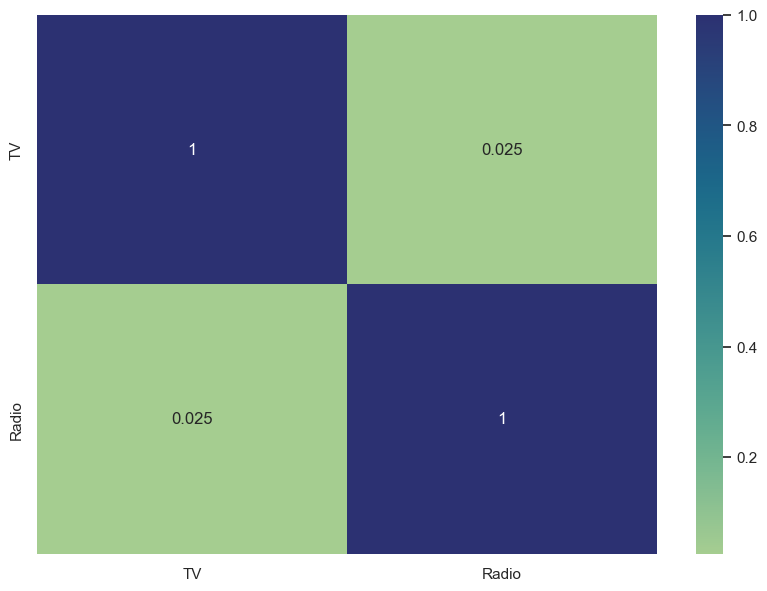

In [23]:
plt.figure(figsize=(10,7))
sns.heatmap(new_X_train.corr(),cmap='crest',annot = True)
print(new_X_train.corr())
plt.show()

In [24]:
vif = pd.DataFrame()
vif["Features"] = new_X.columns
vif["VIF"] = [variance_inflation_factor(new_X.values, i) for i in range(new_X.shape[1])]
vif

,Features,VIF
0,TV,2.238085
1,Radio,2.238085


Since both variables have VIF values significantly lower than 10, it can be concluded that there is no multicollinearity between these variables.

#### Recheck for Homoscedasticity

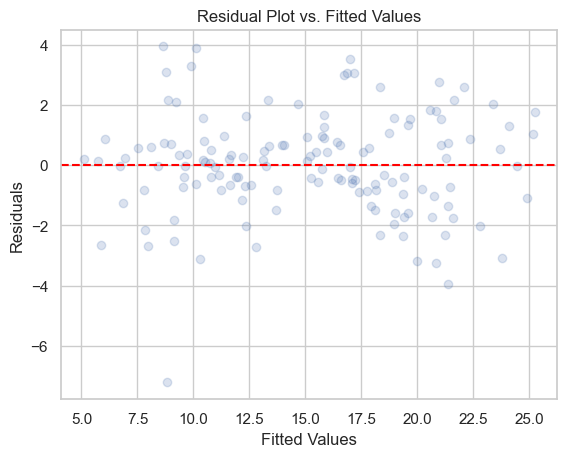

In [25]:
residuals = new_model_sm.resid
fitted_values = new_model_sm.fittedvalues
plt.scatter(fitted_values, residuals,alpha=0.2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot vs. Fitted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Garis referensi untuk residu nol
plt.show()


In [26]:
exog = sm.add_constant(new_model_sm.model.exog)
white_test_statistic, white_p_value, _, _ = het_white(residuals, exog)
alpha = 0.05
print(f"p-value = {white_p_value:.3f}")
if white_p_value > alpha:
    print("There is no heteroscedasticity in the residuals.")
else:
    print("There is heteroscedasticity in the residuals.")

p-value = 0.130
There is no heteroscedasticity in the residuals.


### Feature Importance Linear Regression without Newspaper variable.

  Feature  Importance
1   Radio    0.112323
0      TV    0.055656


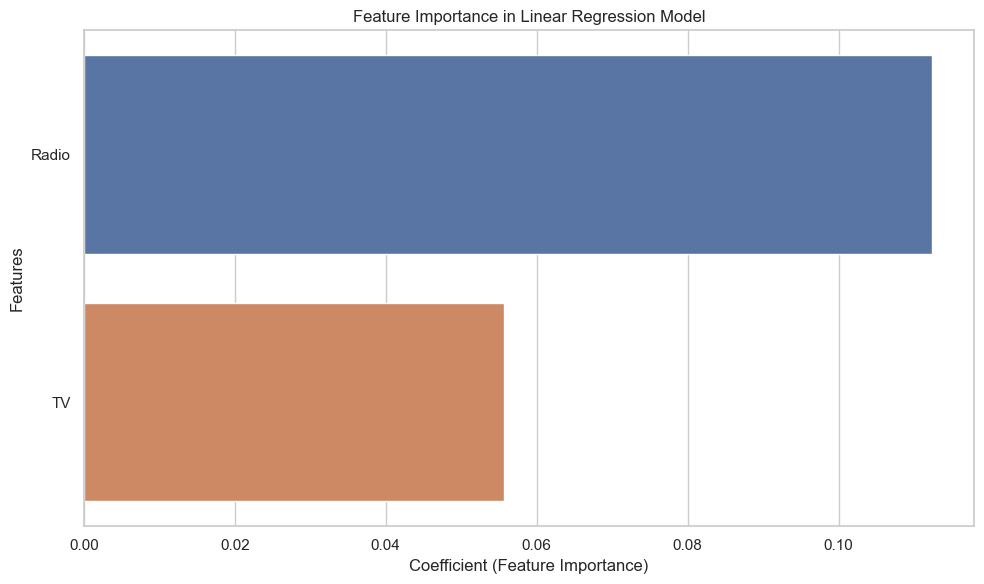

In [27]:
feature_importance = pd.DataFrame({"Feature": new_X.columns, "Importance": new_model.coef_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.xlabel("Coefficient (Feature Importance)")
plt.ylabel("Features")
plt.title("Feature Importance in Linear Regression Model")
plt.tight_layout()
plt.show()

### Linear Regression Evaluation

In [28]:
new_y_pred_lr = new_model.predict(new_X_test)

In [29]:
mse_lr = mean_squared_error(y_test, new_y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, new_y_pred_lr)
r2_lr = r2_score(y_test, new_y_pred_lr)
adjusted_r2_lr = 1 - (1 - r2_lr) * (new_X.shape[0] - 1) / (new_X.shape[0] - new_X.shape[1] - 1)
print("Mean Squared Error:", mse_lr)
print("Mean Absolute Percentage Error:", mape_lr)
print("R-squared:", r2_lr)
print("Adjusted R-squared:", adjusted_r2_lr)

Mean Squared Error: 2.489483742614155
Mean Absolute Percentage Error: 0.08610107191998582
R-squared: 0.9033052064025686
Adjusted R-squared: 0.9023235333711226


## Decision Tree Regressor

In [30]:
dt_model = DecisionTreeRegressor(random_state=154)
# fit model
dt_model.fit(new_X_train, y_train)

DecisionTreeRegressor(random_state=154)

In [31]:
# Predict Data Test
y_pred_dt = dt_model.predict(new_X_test)

### Decision Tree Regressor Evaluation

In [32]:
mse_dt = mean_squared_error(y_test, y_pred_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
adjusted_r2_dt = 1 - (1 - r2_dt) * (new_X.shape[0] - 1) / (new_X.shape[0] - new_X.shape[1] - 1)
print("Mean Squared Error:", mse_dt)
print("Mean Absolute Percentage Error:", mape_dt)
print("R-squared:", r2_dt)
print("Adjusted R-squared:", adjusted_r2_dt)

Mean Squared Error: 2.0743333333333336
Mean Absolute Percentage Error: 0.07147868275694935
R-squared: 0.9194301894463
Adjusted R-squared: 0.9186122218264654


### Feature Importance Decision Tree Regressor

  Feature  Importance
0      TV    0.848027
1   Radio    0.151973


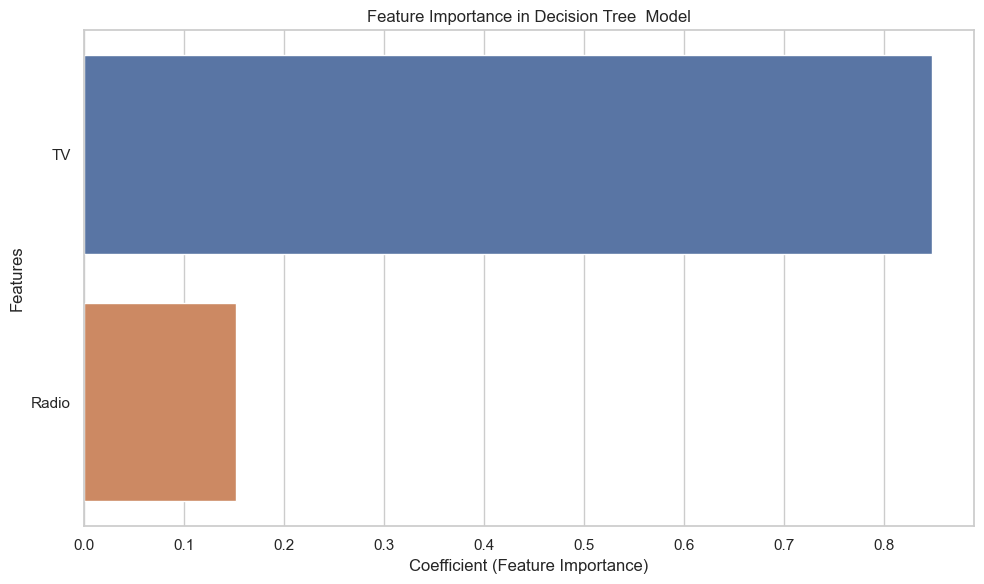

In [33]:
feature_importance_dt = pd.DataFrame({"Feature": new_X.columns, "Importance": dt_model.feature_importances_})
feature_importance_dt = feature_importance_dt.sort_values(by="Importance", ascending=False)

print(feature_importance_dt)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_dt)
plt.xlabel("Coefficient (Feature Importance)")
plt.ylabel("Features")
plt.title("Feature Importance in Decision Tree  Model")
plt.tight_layout()
plt.show()

## Random Forest Regressor

In [34]:
rf_model = RandomForestRegressor(random_state=404)
# fit model
rf_model.fit(new_X_train, y_train)

RandomForestRegressor(random_state=404)

In [35]:
# Predict Data Test
y_pred_rf = rf_model.predict(new_X_test)

### Feature Importance Random Forest Regressor

  Feature  Importance
0      TV    0.845066
1   Radio    0.154934


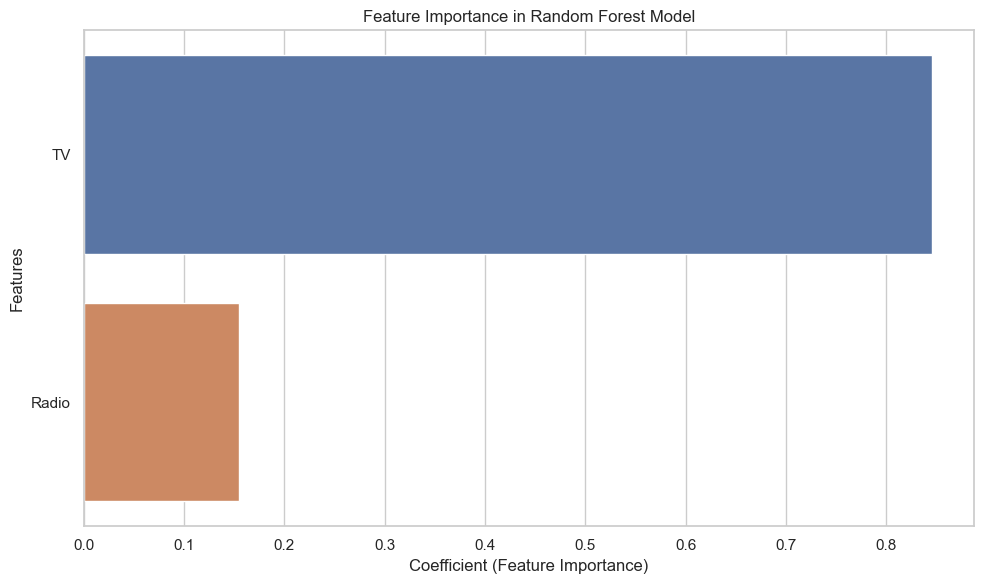

In [39]:
# Create a DataFrame to display the coefficients along with the feature names
feature_importance_rf = pd.DataFrame({"Feature": new_X.columns, "Importance": rf_model.feature_importances_})
feature_importance_rf = feature_importance_rf.sort_values(by="Importance", ascending=False)

print(feature_importance_rf)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_rf)
plt.xlabel("Coefficient (Feature Importance)")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.tight_layout()
plt.show()

#### Evaluation for Random Forest Regressor

In [36]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
adjusted_r2_rf = 1 - (1 - r2_rf) * (new_X.shape[0] - 1) / (new_X.shape[0] - new_X.shape[1] - 1)
print("Mean Squared Error:", mse_rf)
print("Mean Absolute Percentage Error:", mape_rf)
print("R-squared:", r2_rf)
print("Adjusted R-squared:", adjusted_r2_rf)

Mean Squared Error: 0.8799827499999979
Mean Absolute Percentage Error: 0.05265693876441142
R-squared: 0.9658203229352288
Adjusted R-squared: 0.9654733211376169


# Select Best Model

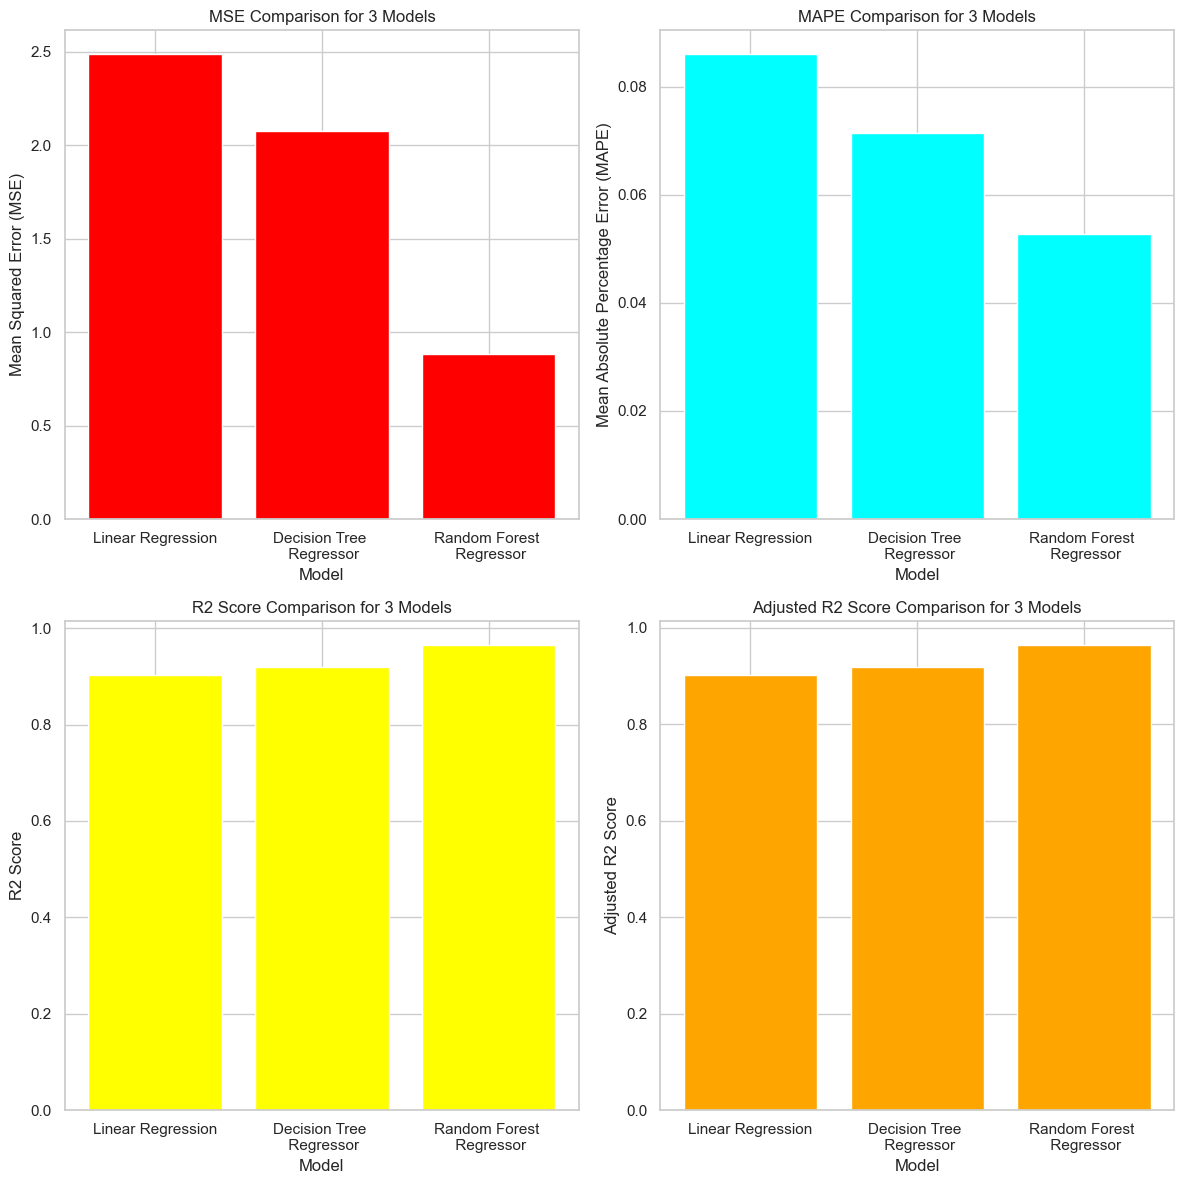

In [37]:
mse_values = [mse_lr, mse_dt, mse_rf]
mape_values = [mape_lr, mape_dt, mape_rf]
r2_values = [r2_lr, r2_dt, r2_rf]
adjusted_r2_values = [adjusted_r2_lr, adjusted_r2_dt, adjusted_r2_rf]

# Define the model names
model_names = ['Linear Regression', 'Decision Tree \n Regressor', 'Random Forest \n Regressor']

# Create a figure and define two subplots (side by side)
fig, axes = plt.subplots(2, 2, figsize=(12,12))

# Plot MSE values
axes[0,0].bar(model_names, mse_values,color='red')
axes[0,0].set_xlabel('Model')
axes[0,0].set_ylabel('Mean Squared Error (MSE)')
axes[0,0].set_title('MSE Comparison for 3 Models')

# Plot MAPE values
axes[0,1].bar(model_names, mape_values, color='cyan')
axes[0,1].set_xlabel('Model')
axes[0,1].set_ylabel('Mean Absolute Percentage Error (MAPE)')
axes[0,1].set_title('MAPE Comparison for 3 Models')

# Plot MAPE values
axes[1,0].bar(model_names, r2_values,color='yellow')
axes[1,0].set_xlabel('Model')
axes[1,0].set_ylabel('R2 Score')
axes[1,0].set_title('R2 Score Comparison for 3 Models')

# Plot MAPE values
axes[1,1].bar(model_names, adjusted_r2_values, color='orange')
axes[1,1].set_xlabel('Model')
axes[1,1].set_ylabel('Adjusted R2 Score')
axes[1,1].set_title('Adjusted R2 Score Comparison for 3 Models')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Based on the evaluation metrics including MSE, MAPE, R2, and adjusted R2 for all the models, the **Random Forest Regression** stands out as the best among the three. This conclusion is drawn from its lowest MSE and MAPE values, as well as its higher R2 and adjusted R2 scores compared to the other models.

# Prediction Result From the Best Model

In [38]:
predict_rf=pd.concat([new_X_test.reset_index(drop=True), pd.Series(y_pred_rf, name='Predicted_RF').reset_index(drop=True)], axis=1)
predict_rf

,TV,Radio,Predicted_RF
0,147.3,23.9,13.715
1,75.5,10.8,10.797
2,250.9,36.5,22.141
3,180.8,10.8,17.083
4,19.4,16.0,7.007
5,73.4,17.0,11.503
6,289.7,42.3,25.406
7,100.4,9.6,11.171
8,70.6,16.0,11.297
9,93.9,43.5,14.280
